In [3512]:
import pandas as pd
import numpy as np
import random

In [3513]:
users = pd.DataFrame(
    columns=[
        "id",
        "createdAt",
        "birthDate",
        "age",
        "ageGroup",
        "address",
        "city",
        "state",
        "country",
        "lastLogin",
        "firstAccountType",
        "daysFromLastLogin",
    ]
)

accounts = pd.DataFrame(
    columns=[
        "id",
        "userId",
        "createdAt",
        "accountType",
        "balance",
        "status",
        "lastActivityDate",
        "lastTransferDate",
    ]
)

transfers = pd.DataFrame(
    columns=[
        "id",
        "amount",
        "accountType",
        "minute",
        "hour",
        "date",
        "createdAt",
        "scheduled",
        "status",
        "fromId",
        "toId",
    ]
)

# Mocando dados

In [3514]:
from datetime import datetime, timedelta
from scipy.stats import skewnorm
from matplotlib import pyplot as plt

rng = np.random.default_rng(30)

USER_COUNT = 10000
ACCOUNT_COUNT = 30000
TRANSFER_COUNT = 100000

## users

### id

In [3515]:
users['id'] = range(0, USER_COUNT)
users.set_index('id', inplace=True)
users.index.name = None

### address

In [3516]:
cidades_brasil = pd.read_csv(
    "./ibge_cidades.csv",
    sep=",",
    encoding="utf-8",
)

cidades_brasil.head()

cidades_brasil.drop(
    columns=["ConcatUF+Mun", "IBGE", "IBGE7", "Unnamed: 9"], inplace=True
)

cidades_brasil = cidades_brasil[cidades_brasil["População 2010"].isnull() == False]

populacao_total = cidades_brasil["População 2010"].sum()
cidades_brasil["Porcentagem da População"] = (
    cidades_brasil["População 2010"] / populacao_total
)

In [3517]:
weights = cidades_brasil["Porcentagem da População"].values
weights = weights / np.sum(weights)
cidades_brasil["weights"] = weights
cidades_brasil["weights"] = cidades_brasil["weights"].apply(lambda x: float(x))

In [3518]:
city_state = rng.choice(cidades_brasil[['Município', 'UF']], size=USER_COUNT, p=cidades_brasil['weights'].values)
city_state = pd.DataFrame(city_state, columns=['city', 'state'])

In [3519]:
users['state'] = city_state['state']
users['city'] = city_state['city']
users['address'] = users['city'] + ', ' + users['state'] + ', Brasil'
users['country'] = 'Brasil'

### createdAt

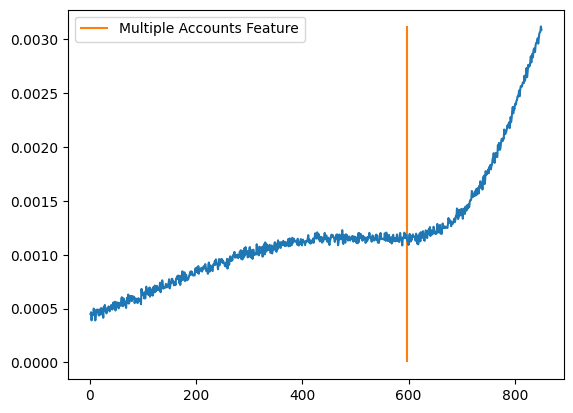

In [3520]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Gerando range de dias
first_day = 1
last_day = end - start
last_day = last_day.days
lin_range = np.linspace(0, 1, last_day - first_day + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17

# Gerando as distribuições de pesos
weights1 = skewnorm.pdf(x=lin_range,
                        a=a1,
                        loc=loc1,
                        scale=scale1)
weights2 = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)
weights = weights1 + weights2

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round((last_day + 1) * 0.7)

plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

In [3521]:
created_at = rng.choice(np.linspace(1, last_day, last_day - first_day + 1), size=USER_COUNT, p=weights
)
users['createdAt'] = created_at
users['createdAt'] = users['createdAt'].apply(lambda x: start + timedelta(days=x))

### birthdate

Pico de usuários nascidos na faixa de 1998 a 2004


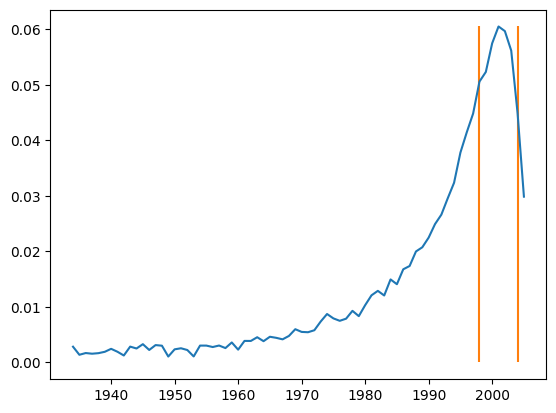

In [3522]:
from scipy.stats import alpha

# Gerando range de anos
initial_days = 1934
last_day = 2005
lin_range = np.linspace(0, 1, last_day - initial_days + 1)


# Gerando pesos para os anos
a = 1
loc = -0.1
scale = 0.3
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)
weights = np.flip(weights)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=last_day - initial_days + 1))
weights = weights / np.sum(weights)

print('Pico de usuários nascidos na faixa de 1998 a 2004')

plt.gca().vlines(np.array([1998, 2004]), ymin=0, ymax=np.max(weights), colors='C1')
plt.plot(np.arange(initial_days, last_day + 1), weights)
plt.show()

In [3523]:
def gen_random_date(year):
    day = random.randint(1, 31)
    month = random.randint(1, 12)
    if month == 2 and day > 28:
        day = 28
    if month in [4, 6, 9, 11] and day > 30:
        day = 30
    if month == 2 and day == 29:
        if year % 4 != 0 or (year % 100 == 0 and year % 400 != 0):
            day = 28
    birth_date = pd.Timestamp(
        year=year, month=month, day=day, hour=0, minute=0, second=0
    )
    return birth_date 

In [3524]:
users["birthDate"] = rng.choice(
    np.arange(initial_days, last_day + 1), size=USER_COUNT, p=weights
)

users["birthDate"] = users["birthDate"].apply(gen_random_date)

In [3525]:
users["age"] = (end - users["birthDate"]).dt.days // 365

In [3526]:
age_groups = [
    {"name": "18-24", "min": 18, "max": 24},
    {"name": "25-31", "min": 25, "max": 31},
    {"name": "32-48", "min": 32, "max": 38},
    {"name": "39-45", "min": 39, "max": 45},
    {"name": "46-52", "min": 46, "max": 52},
    {"name": "53-59", "min": 53, "max": 59},
    {"name": "60-66", "min": 60, "max": 66},
    {"name": "67-73", "min": 67, "max": 73},
    {"name": "74-80", "min": 74, "max": 80},
    {"name": "81+", "min": 81, "max": 100},
]

get_age_group = lambda x: [
    group["name"] for group in age_groups if group["min"] <= x <= group["max"]
]

users["ageGroup"] = users["age"].apply(lambda x: get_age_group(x)[0])

### firstAccountType

In [3527]:
account_types = ['Conta Corrente', 'Conta Poupança']
users['firstAccountType'] = rng.choice(account_types, size=USER_COUNT, p=[0.67, 0.33])

### lastLoginDate

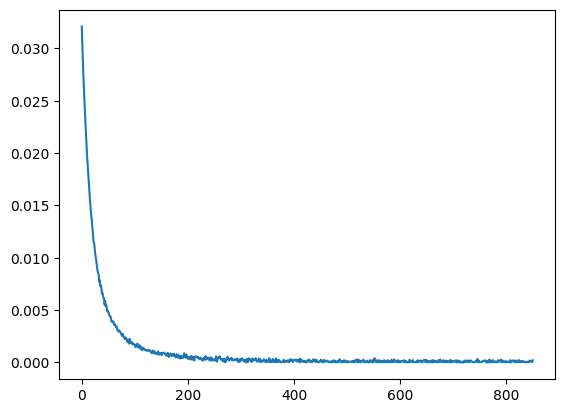

In [3528]:
from scipy.stats import alpha

# Gerando range de anos
first_day = 0
last_day = 850
lin_range = np.linspace(0, 1, last_day - first_day + 1)


# Gerando pesos para os anos
a = 1
loc = -0.04
scale = 0.05
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=last_day - first_day + 1))
weights = weights / np.sum(weights)


plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

In [3529]:
users['daysFromCreation'] = (pd.to_datetime('2024-04-30') - users['createdAt']).dt.days

In [3530]:
last_login = rng.choice(
    np.linspace(0, 1, (last_day - first_day + 1)), size=USER_COUNT, p=weights
)

In [3531]:
users['daysFromLastLogin'] = round(last_login * users['daysFromCreation']).astype(int)

In [3532]:
users['lastLogin'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(users['daysFromLastLogin'], unit='d')

In [3533]:
users.describe()

,createdAt,birthDate,age,lastLogin,daysFromLastLogin,daysFromCreation
count,10000,10000,10000.000000,10000,10000.00000,10000.000000
mean,2023-06-05 08:55:40.800000,1990-09-10 13:35:54.240000,33.163300,2024-03-29 20:18:57.600000,31.15350,329.628000
min,2022-01-02 00:00:00,1934-01-05 00:00:00,18.000000,2022-03-02 00:00:00,0.00000,0.000000
25%,2022-11-25 00:00:00,1985-06-25 12:00:00,23.000000,2024-04-04 00:00:00,2.00000,108.000000
50%,2023-07-04 00:00:00,1995-10-22 00:00:00,28.000000,2024-04-23 00:00:00,7.00000,301.000000
75%,2024-01-13 00:00:00,2000-12-24 06:00:00,38.000000,2024-04-28 00:00:00,26.00000,522.000000
max,2024-04-30 00:00:00,2005-12-29 00:00:00,90.000000,2024-04-30 00:00:00,790.00000,849.000000
std,NaN,NaN,14.772057,NaN,71.77621,239.156027


In [3534]:
users.head()

,createdAt,birthDate,age,ageGroup,address,city,state,country,lastLogin,firstAccountType,daysFromLastLogin,daysFromCreation
0,2022-10-26,1995-06-20,28,25-31,"Lajedo, PE, Brasil",Lajedo,PE,Brasil,2024-03-30,Conta Poupança,31,552
1,2023-12-05,1987-11-28,36,32-48,"Novo Cruzeiro, MG, Brasil",Novo Cruzeiro,MG,Brasil,2024-02-05,Conta Poupança,85,147
2,2024-01-21,2003-11-10,20,18-24,"Coelho Neto, MA, Brasil",Coelho Neto,MA,Brasil,2024-04-29,Conta Poupança,1,100
3,2022-10-13,1971-02-27,53,53-59,"Campo Limpo Paulista, SP, Brasil",Campo Limpo Paulista,SP,Brasil,2024-04-11,Conta Poupança,19,565
4,2024-01-10,2001-01-22,23,18-24,"Estiva Gerbi, SP, Brasil",Estiva Gerbi,SP,Brasil,2024-04-28,Conta Corrente,2,111


## accounts

### users with multiple accounts

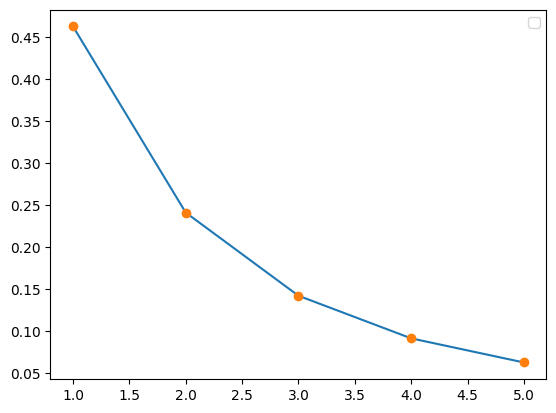

In [3535]:
# Gerando range de contas
min_accounts = 1
max_accounts = 5
lin_range = np.linspace(0, 1, max_accounts - min_accounts + 1)

# Gerando pesos
a = 5
loc = -1.5
scale = 0.8

# Gerando as distribuições de pesos
weights = alpha.pdf(x=lin_range,
                        a=a,
                        loc=loc,
                        scale=scale)
weights = weights / np.sum(weights)

plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(min_accounts, max_accounts + 1), weights)
plt.plot(np.arange(min_accounts, max_accounts + 1), weights, 'o')
plt.show()

In [3536]:
users['accountCount'] = rng.choice(
    np.arange(min_accounts, max_accounts + 1), size=USER_COUNT, p=weights
)
users['accountCount'].value_counts()

accountCount
1    4598
2    2431
3    1416
4     950
5     605
Name: count, dtype: int64

### id

In [3537]:
accounts['id'] = range(0, ACCOUNT_COUNT)
accounts.set_index('id', inplace=True)
accounts.index.name = None

### accountType

In [3538]:
accounts['status'] = rng.choice(['active', 'blocked', 'inactive'], size=ACCOUNT_COUNT, p=[0.9, 0.06, 0.04])

### usersFirstAccount

In [3539]:
first_accounts = accounts.loc[0:USER_COUNT - 1].copy()
first_accounts[['createdAt', 'accountType']] = users[['createdAt', 'firstAccountType']]
first_accounts['userId'] = users.index
accounts.update(first_accounts)

### other accounts

In [3540]:
last_index = accounts[accounts['userId'].isnull()].head(1).index[0] - 1
n_accounts = 0
for index, row in users.iterrows():
    for i in range(row['accountCount'] - 1):
        n_accounts += 1
        last_index += 1
        accounts.at[last_index, 'userId'] = index

In [3541]:
accounts.groupby('userId').size().value_counts()

1    4598
2    2431
3    1416
4     950
5     605
Name: count, dtype: int64

In [3542]:
accounts['userId'] = accounts['userId'].astype('Int64')

In [3543]:
accounts = accounts.dropna(subset=['userId'])

### accountType

In [3544]:
other_accounts = accounts[accounts['createdAt'].isnull()].copy()

In [3545]:
other_accounts['accountType'] = rng.choice(account_types, size=other_accounts.shape[0], p=[0.53, 0.47])

In [3546]:
accounts = accounts.drop(range(USER_COUNT, other_accounts.shape[0]))

In [3547]:
accounts = pd.concat([accounts.copy(), other_accounts.copy()])

### createdAt

In [3548]:
accounts['userCreatedAt'] = accounts['userId'].map(users['createdAt'])

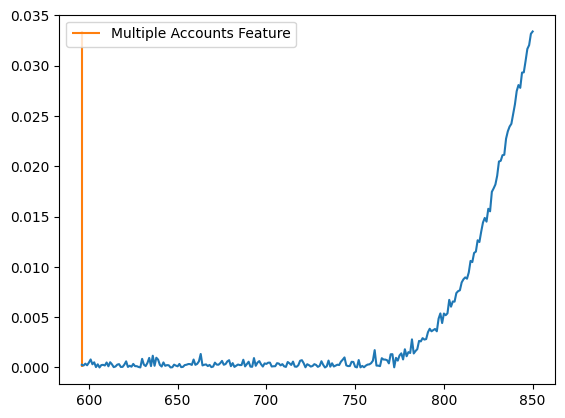

Dias após o lançamento do App para implementação da feature de múltiplas contas:  596
Data de implementação da feature de múltiplas contas:  2023-08-20 00:00:00


In [3549]:
# Lançamento do App - 01/01/2022
# Última coleta de dados sobre o App - 30/04/2024
start = pd.to_datetime("2022-01-01")
end = pd.to_datetime("2024-04-30")

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round(((last_day + 1) * 0.7))

# Gerando range de dias
first_day = feature_multiple_accounts
last_day = end - start
last_day = last_day.days
lin_range = np.linspace(0, 1, last_day - first_day + 1)

# Gerando pesos
a1 = 1
loc1 = 0.3
scale1 = 0.5
a2 = -1
loc2 = 1.2
scale2 = 0.17


weights = skewnorm.pdf(x=lin_range,
                        a=a2,
                        loc=loc2,
                        scale=scale2)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.025, size=last_day - first_day + 1))
weights = weights / np.sum(weights)



plt.gca().vlines(np.array([feature_multiple_accounts]), ymin=0, ymax=np.max(weights), colors='C1')
plt.legend(['Multiple Accounts Feature'])
plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()
print('Dias após o lançamento do App para implementação da feature de múltiplas contas: ', feature_multiple_accounts)
print('Data de implementação da feature de múltiplas contas: ', pd.to_datetime('2022-01-01') + pd.to_timedelta(feature_multiple_accounts, unit='d'))

In [3550]:
accounts['daysFromUserCreation'] = round((pd.to_datetime('2024-04-30') - accounts['userCreatedAt']).dt.days).astype(int)

In [3551]:
created_at = rng.choice(
    np.linspace(0, 1, (last_day - first_day + 1)), size=accounts.shape[0], p=weights
)

In [3552]:
accounts['createdAt'] = round(created_at * accounts['daysFromUserCreation']).astype(int)

In [3553]:
accounts['createdAt'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(accounts['createdAt'], unit='d')

### lastTransferDate

#### first accounts

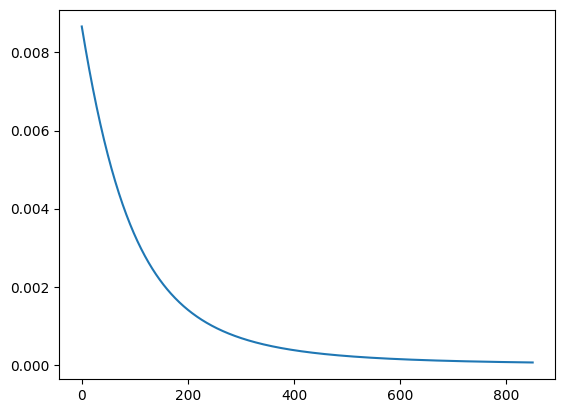

In [3554]:
from scipy.stats import alpha

# Gerando range de anos
first_day = 0
last_day = 850
lin_range = np.linspace(0, 1, last_day - first_day + 1)


# Gerando pesos para os anos
a = 3
loc = -0.4
scale = 1
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
# weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

In [3555]:
first_accounts = accounts.loc[0:USER_COUNT - 1].copy()

In [3556]:
first_accounts['daysFromCreation'] = (pd.to_datetime('2024-04-30') - first_accounts['createdAt']).dt.days

In [3557]:
last_transfer = rng.choice(
    np.linspace(0, 1, (last_day - first_day + 1)), size=first_accounts.shape[0], p=weights
)

In [3558]:
first_accounts['daysFromLastTransfer'] = round(last_transfer * first_accounts['daysFromCreation']).astype(int)

In [3559]:
first_accounts['lastTransferDate'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(first_accounts['daysFromLastTransfer'], unit='d')

#### other accounts

In [3560]:
from scipy.stats import alpha

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round(((last_day + 1) * 0.7))

# Gerando range de dias
first_day = feature_multiple_accounts
# Gerando range de anos
first_day = 0
last_day = 850
lin_range = np.linspace(0, 1, last_day - first_day + 1)


# Gerando pesos para os anos
a = 3
loc = -0.4
scale = 1
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

In [3561]:
other_accounts = accounts.loc[USER_COUNT:].copy()

In [3562]:
last_activity = rng.choice(
    np.linspace(0, 1, (last_day - first_day + 1)), size=other_accounts.shape[0], p=weights
)

In [3563]:
other_accounts['daysFromLastTransfer'] = round(last_activity * other_accounts['daysFromUserCreation']).astype(int)

In [3564]:
other_accounts['lastTransferDate'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(other_accounts['daysFromLastTransfer'], unit='d')

In [3565]:
accounts = pd.concat([first_accounts, other_accounts])

### lastActivityDate

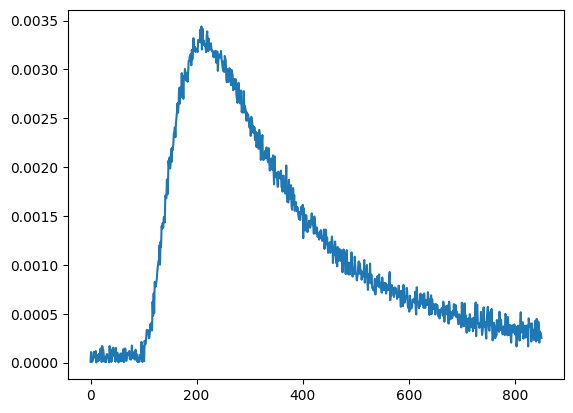

In [3566]:
from scipy.stats import alpha

# Adição da feature múltiplas contas ao app
feature_multiple_accounts = round(((last_day + 1) * 0.7))

# Gerando range de dias
first_day = feature_multiple_accounts
# Gerando range de anos
first_day = 0
last_day = 850
lin_range = np.linspace(0, 1, last_day - first_day + 1)


# Gerando pesos para os anos
a = 1
loc = 0
scale = 0.5
weights = alpha.pdf(x=lin_range, a=a, loc=loc, scale=scale)

# Gerando ruído nos pesos
weights = np.abs(weights + rng.normal(loc=0, scale=0.05, size=last_day - first_day + 1))
weights = weights / np.sum(weights)

plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

In [3567]:
accounts['daysFromLastTransfer'] = (pd.to_datetime('2024-04-30') - accounts['lastTransferDate']).dt.days


In [3568]:
last_activity = rng.choice(
    np.linspace(0, 1, (last_day - first_day + 1)), size=accounts.shape[0], p=weights
)

In [3569]:
accounts['daysFromLastActivity'] = round(last_activity * accounts['daysFromLastTransfer']).astype(int)

In [3570]:
accounts['lastActivityDate'] = pd.to_datetime('2024-04-30') - pd.to_timedelta(accounts['daysFromLastActivity'], unit='d')

In [3572]:
users.describe()

,createdAt,birthDate,age,lastLogin,daysFromLastLogin,daysFromCreation,accountCount
count,10000,10000,10000.000000,10000,10000.00000,10000.000000,10000.000000
mean,2023-06-05 08:55:40.800000,1990-09-10 13:35:54.240000,33.163300,2024-03-29 20:18:57.600000,31.15350,329.628000,2.053300
min,2022-01-02 00:00:00,1934-01-05 00:00:00,18.000000,2022-03-02 00:00:00,0.00000,0.000000,1.000000
25%,2022-11-25 00:00:00,1985-06-25 12:00:00,23.000000,2024-04-04 00:00:00,2.00000,108.000000,1.000000
50%,2023-07-04 00:00:00,1995-10-22 00:00:00,28.000000,2024-04-23 00:00:00,7.00000,301.000000,2.000000
75%,2024-01-13 00:00:00,2000-12-24 06:00:00,38.000000,2024-04-28 00:00:00,26.00000,522.000000,3.000000
max,2024-04-30 00:00:00,2005-12-29 00:00:00,90.000000,2024-04-30 00:00:00,790.00000,849.000000,5.000000
std,NaN,NaN,14.772057,NaN,71.77621,239.156027,1.234185


In [3571]:
accounts.describe()

,userId,createdAt,lastActivityDate,lastTransferDate,userCreatedAt,daysFromUserCreation,daysFromCreation,daysFromLastTransfer,daysFromLastActivity
count,20533.0,20533,20533,20533,20533,20533.000000,10000.000000,20533.000000,20533.000000
mean,5015.390445,2023-07-12 02:18:30.524521472,2024-04-08 08:19:11.551161600,2024-03-08 00:59:36.681439488,2023-06-04 20:47:08.383577600,330.133931,292.224200,52.958603,21.653339
min,0.0,2022-01-06 00:00:00,2022-10-12 00:00:00,2022-01-25 00:00:00,2022-01-02 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2514.0,2023-01-19 00:00:00,2024-04-07 00:00:00,2024-02-29 00:00:00,2022-11-26 00:00:00,109.000000,89.750000,5.000000,2.000000
50%,5057.0,2023-08-15 00:00:00,2024-04-23 00:00:00,2024-04-09 00:00:00,2023-07-01 00:00:00,304.000000,258.000000,21.000000,7.000000
75%,7485.0,2024-01-31 00:00:00,2024-04-28 00:00:00,2024-04-25 00:00:00,2024-01-12 00:00:00,521.000000,467.000000,61.000000,23.000000
max,9999.0,2024-04-30 00:00:00,2024-04-30 00:00:00,2024-04-30 00:00:00,2024-04-30 00:00:00,849.000000,845.000000,826.000000,566.000000
std,2880.555203,NaN,NaN,NaN,NaN,238.874477,221.371572,85.843630,40.131808
